In [ ]:
from zipfile import ZipFile
import os
import numpy as np
import pandas as pd
import shutil
import keras
from keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


# Reading datasets

In [ ]:
# Download files
!wget -O images.zip --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vtO5_FB--urbF09XYoxbSAEQW-yqwoi6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vtO5_FB--urbF09XYoxbSAEQW-yqwoi6" && rm -rf /tmp/cookies.txt

!wget -O train.csv --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XQ-RfUG1C_6LUZdRUe9nAU77I_AZFH-F' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XQ-RfUG1C_6LUZdRUe9nAU77I_AZFH-F" && rm -rf /tmp/cookies.txt

--2020-04-19 00:56:45--  https://docs.google.com/uc?export=download&confirm=5pxt&id=1vtO5_FB--urbF09XYoxbSAEQW-yqwoi6
Resolving docs.google.com (docs.google.com)... 173.194.195.102, 173.194.195.100, 173.194.195.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.195.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-64-docs.googleusercontent.com/docs/securesc/l0u352idq9sl5l3hlr4mivkhoqi3plib/c994n06plueuc2acf3oinqdfu747lbih/1587257775000/12463928819926971683/00976242672614604319Z/1vtO5_FB--urbF09XYoxbSAEQW-yqwoi6?e=download [following]
--2020-04-19 00:56:45--  https://doc-10-64-docs.googleusercontent.com/docs/securesc/l0u352idq9sl5l3hlr4mivkhoqi3plib/c994n06plueuc2acf3oinqdfu747lbih/1587257775000/12463928819926971683/00976242672614604319Z/1vtO5_FB--urbF09XYoxbSAEQW-yqwoi6?e=download
Resolving doc-10-64-docs.googleusercontent.com (doc-10-64-docs.googleusercontent.com)... 172.217.212.132, 2607:f8b0:4001:c03::84
Conne

In [ ]:
with ZipFile('images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [ ]:
try:
    os.mkdir("train_set")
    os.mkdir("train_set/0")
    os.mkdir("train_set/1")
    os.mkdir("val_set")
    os.mkdir("val_set/0")
    os.mkdir("val_set/1")
except OSError:
    print ("Creation of the directory failed")

In [ ]:
train_df = pd.read_csv("train.csv")

In [ ]:
train_names = []
y = []
val_indices = list(random.sample(range(0, 1308), 200))
train_indices = [c for c in range(1308) if c not in val_indices]

for i in range(1308):
    image_name = train_df.loc[i][0]
    class_name = int(train_df.loc[i][1])
    y.append(class_name)
    if class_name==0:
        shutil.copy("images/"+image_name, 'train_set/0')
    else:
        shutil.copy("images/"+image_name, 'train_set/1')
    train_names.append(image_name)

for i in val_indices:
    image_name = train_df.loc[i][0]
    class_name = int(train_df.loc[i][1])
    y.append(class_name)
    if class_name==0:
        shutil.copy("images/"+image_name, 'val_set/0')
    else:
        shutil.copy("images/"+image_name, 'val_set/1')
    train_names.append(image_name)

In [ ]:
try:
    os.mkdir("test_set")
except OSError:
    print ("Creation of the directory failed")

test_names = []
for image_name in os.listdir("images"):
    if image_name not in train_names:
        test_names.append(image_name)
        shutil.copy("images/"+image_name, 'test_set')

# Pre-trained models hands-on

In [ ]:
import keras
import numpy as np
from keras.applications import vgg16
 
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')


Using TensorFlow backend.


553467904/553467096 [==============================] - 6s 0us/step


PIL image size (224, 224)


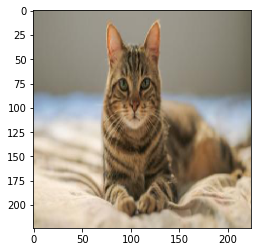

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline

filename = 'images/cat.jpg'
# load an image in PIL format
original = load_img(filename, target_size=(224, 224))
print('PIL image size',original.size)
plt.imshow(original)
plt.show()



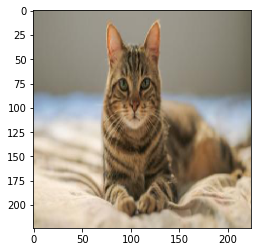

numpy array size (224, 224, 3)


In [ ]:
# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)
plt.imshow(np.uint8(numpy_image))
plt.show()
print('numpy array size',numpy_image.shape)

image batch size (1, 224, 224, 3)


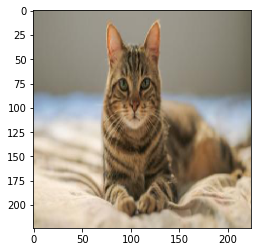

In [ ]:
# Convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels)
# Thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)
plt.imshow(np.uint8(image_batch[0]))

In [ ]:
# prepare the image for the VGG model
processed_image = vgg16.preprocess_input(image_batch.copy())

# get the predicted probabilities for each class
predictions = vgg_model.predict(processed_image)
# print predictions

# convert the probabilities to class labels
# We will get top 5 predictions which is the default
label = decode_predictions(predictions)
print(label)

40960/35363 [==================================] - 0s 0us/step
[[('n02124075', 'Egyptian_cat', 0.619432), ('n02123045', 'tabby', 0.18091668), ('n02123159', 'tiger_cat', 0.13934767), ('n02127052', 'lynx', 0.00436706), ('n04040759', 'radiator', 0.0039377357)]]


# ResNet

In [ ]:
num_classes = 2

my_new_model = Sequential()
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))
my_new_model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

my_new_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        'train_set',
        target_size = (image_size, image_size),
        batch_size = 24
)


my_new_model.fit_generator(
        train_generator,
        steps_per_epoch=3,
        validation_data=train_generator,
        validation_steps=1)

Found 1308 images belonging to 2 classes.
3/3 [==============================] - 11s 4s/step - loss: 0.4106 - accuracy: 0.8472 - val_loss: 0.4271 - val_accuracy: 0.7917


# ResNet with val set

In [ ]:
num_classes = 2

my_new_model_val = Sequential()
my_new_model_val.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))
my_new_model_val.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
my_new_model_val.layers[0].trainable = False

my_new_model_val.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
y

In [ ]:
image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        'train_set',
        target_size = (image_size, image_size),
        batch_size = 37
)

my_new_model.fit_generator(
        train_generator,
        steps_per_epoch=3,
        validation_data=train_generator,
        validation_steps=1)

Found 1308 images belonging to 2 classes.
3/3 [==============================] - 17s 6s/step - loss: 0.1295 - accuracy: 0.9640 - val_loss: 0.0667 - val_accuracy: 0.9730


# ResNet changing batch

In [ ]:
num_classes = 2

my_new_model = Sequential()
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet"))
my_new_model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

my_new_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
image_size = 224
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     preprocessing_function=preprocess_input)
data_generator = ImageDataGenerator(**data_gen_args)

for b in range(20, 50):
    train_generator = data_generator.flow_from_directory(
            'train_set',
            target_size = (image_size, image_size),
            batch_size = b
    )
    print(b)
    my_new_model.fit_generator(
            train_generator,
            steps_per_epoch=3,
            validation_data=train_generator,
            validation_steps=1)

# fastAI

In [ ]:
from pathlib import Path

from fastai.basic_data import DatasetType
from fastai.callbacks import SaveModelCallback
from fastai.metrics import accuracy
from fastai.train import ClassificationInterpretation
from fastai.vision.data import ImageList
from fastai.vision.learner import cnn_learner
from fastai.vision.models import resnet18, resnet34, resnet50, resnet101, resnet152, 
squeezenet1_0, squeezenet1_1, densenet121, densenet169, densenet201, vgg16_bn, vgg19_bn,alexnet
from fastai.vision.transform import ResizeMethod, get_transforms
from fastai.vision import imagenet_stats

import pandas as pd

## Reading data

In [ ]:
try:
    os.mkdir("test")
    os.mkdir("train")
    os.mkdir("val")
except OSError:
    print ("Creation of the directory failed")

Creation of the directory failed


In [ ]:
pd.DataFrame(test_names, columns=["image"]).to_csv("test.csv", index=False)

In [ ]:
path = Path('')
il = ImageList.from_csv(path, 'train.csv', folder='images')
sd = il.split_by_rand_pct(0.15)
ll = sd.label_from_df()
ll = ll.transform(get_transforms(), size=224)
data = ll.databunch(bs=64).normalize(imagenet_stats)

In [ ]:
test = (ImageList.from_csv(path, 'test.csv', folder='images'))
data.add_test(test)

In [ ]:
data.show_batch(3)

## Model resnet18

In [ ]:
learn = cnn_learner(data, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

### Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


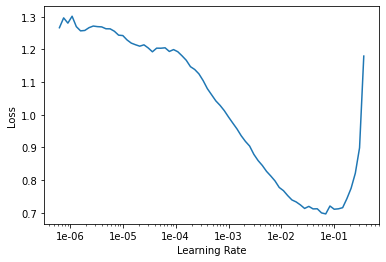

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.542083,0.766194,0.887755,03:14
1,0.358629,0.188002,0.933673,03:19
2,0.247306,0.112990,0.969388,03:14


In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


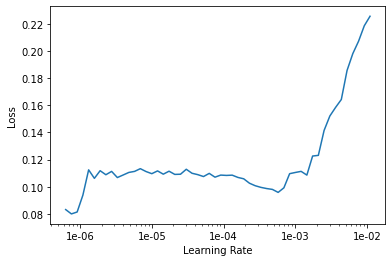

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-6

In [ ]:
learn.fit_one_cycle(3, slice(lr/10,lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.106173,0.108372,0.969388,04:50
1,0.110590,0.113659,0.969388,05:03
2,0.106900,0.114915,0.969388,05:04


## Model resnet18 with augmented data

In [ ]:
learn = cnn_learner(data, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
learn = learn.mixup()

In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

### Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


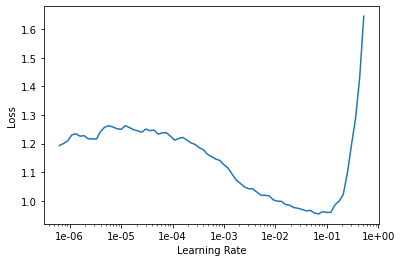

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-1

In [ ]:
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.009826,7.587448,0.505102,03:34
1,1.924722,2.966668,0.464286,03:33
2,1.504137,0.665283,0.678571,03:35


In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


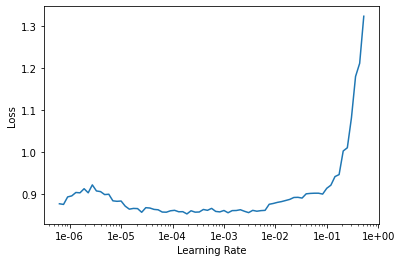

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_one_cycle(3, slice(lr/10,lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.874669,1.246198,0.617347,05:02
1,0.835309,1.613911,0.586735,05:00
2,0.777896,0.524026,0.770408,05:00


## Model resnet 50

In [ ]:
learn = cnn_learner(data, resnet152, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

### Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


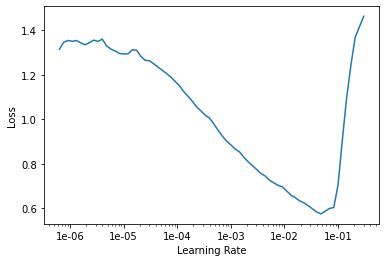

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 4*1e-2

In [ ]:
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.608012,155.104828,0.545918,03:14
1,0.851870,76.563339,0.454082,03:12
2,0.619108,0.294727,0.933673,03:17


In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


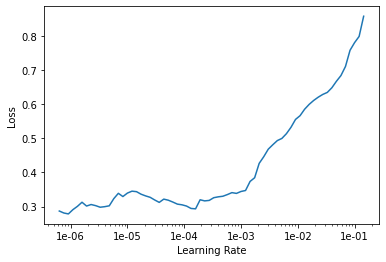

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 8*1e-7

In [ ]:
learn.fit_one_cycle(5, slice(lr/10,lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.296209,0.177281,0.923469,05:25
1,0.313860,0.179119,0.923469,05:03
2,0.306133,0.182618,0.918367,05:14
3,0.309636,0.175686,0.923469,05:23
4,0.308173,0.177291,0.923469,05:33


## Submission

In [ ]:
preds, y = learn.get_preds(DatasetType.Test)

In [ ]:
fnames = [o.split('/')[-1] for o in learn.data.test_ds.items]
subm = pd.DataFrame({'image': fnames, 'target': preds[:, 1]})
subm.to_csv('sub.csv', index=None)

# Misc

In [ ]:
xception_model = keras.applications.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

91889664/91884032 [==============================] - 1s 0us/step


## Predict

In [ ]:
best_model = my_new_model

In [ ]:
predictions = []
test_set_names = list(os.listdir("test_set"))
for test_image in test_set_names:
    img = image.load_img("test_set/"+test_image, target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = best_model.predict_classes(images, batch_size=10)
    predictions.append(classes[0])

submission = pd.DataFrame({'image': test_set_names, 'target': predictions})
submission.to_csv("simpleSub 2.csv", index=False)